In [325]:
import numpy as np
import matplotlib.pyplot as plt

#add different folder
import sys
sys.path.append('../Code')
import noise as ns

In [115]:
ou =  ns.OU_noise(sigma = 50, gamma = 1/1e6, x0 = 0)

(0.0, 400.0)

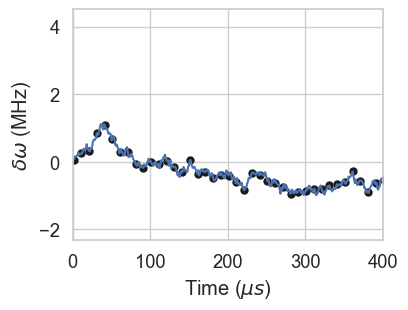

In [116]:
import seaborn as sns

y = []
L = 5000
for k in range(int(L)):
    y.append(ou.update(1))



(0.0, 50.0)

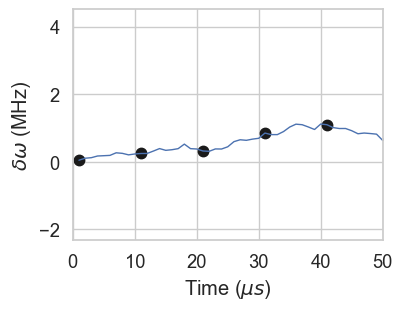

In [139]:

# Apply the default theme
sns.set(font_scale=1.2,style='whitegrid')
plt.figure(figsize=(4, 3))
x = np.linspace(1,L,int(L))

for k in range(10):
    plt.plot(x[::10][0+k*50:10+k*50],y[::10][k*50:10+k*50],"k.", ms = 15)
    plt.plot(x[::10][10+k*50:50+k*50],y[::10][10+k*50:50+k*50],"k.", ms = 15)

plt.plot(x,y,"-", lw=1)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("$\delta \omega$ (MHz)")
plt.xlim(0,50)

Text(0, 0.5, '$\\delta \\omega$ (MHz)')

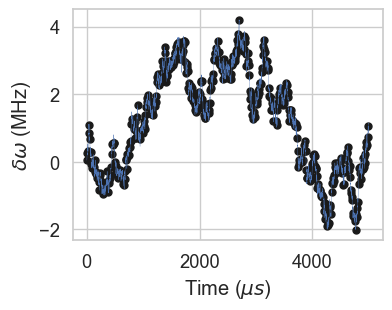

In [123]:

# Apply the default theme
sns.set(font_scale=1.2,style='whitegrid')
plt.figure(figsize=(4, 3))
x = np.linspace(1,L,int(L))

plt.plot(x[::10],y[::10],"k.", ms = 10)
plt.plot(x,y,"-",lw=0.25)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("$\delta \omega$ (MHz)")


# Plot results vs penalty

1.951114425599027
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_34249/4262366028.py:20: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c


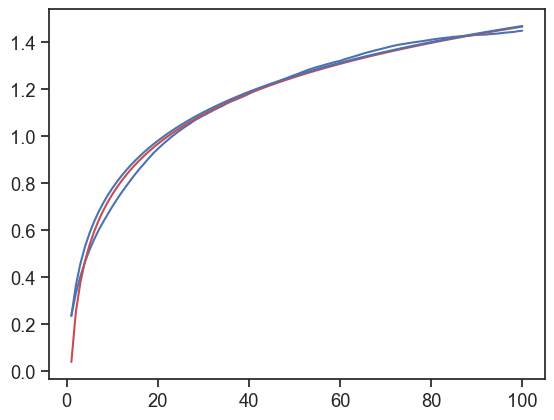

In [402]:
noise1f = nois.Over_f_noise(n_fluctuators = 20, S1 = 1e-2*0.1, sigma_couplings = 0.1, ommax = 1/10, ommin = 1/200000)
y = []
for k in range(20000):
    y.append(noise1f.update(1))

y = np.array(y)
stds = []
for k in range(100):
    k = k+1
    stds.append(np.mean(np.abs(y[k:] - y[:-k])))

print(np.std(y))


import numpy as np
from scipy.optimize import curve_fit
#fit the stds function to a log
# Define the form of the function you want to fit
def func(x, a, b,c):
    return a*np.log(b*x)+c

# Generate some data
x = np.arange(1, 101)
popt, pcov = curve_fit(func, x, stds)

a,b,c = popt
sig = lambda x: x + a*np.log(1+1/(np.exp((x-c)/a)/b))
y = [sig(0)]
for k in range(99):
    y.append(sig(y[-1]))

# Plot the data and the fitted model
plt.plot(x, stds, 'b', label='data')
plt.plot(x, func(x, *popt), 'r')
plt.plot(x,y)
cs = popt

In [403]:
import moments_backend as est
import noise as nois
import optimisation as opt
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
#import monitor
from stable_baselines3.common.monitor import Monitor
import importlib
importlib.reload(nois)
importlib.reload(opt)
importlib.reload(est)

<module 'moments_backend' from '/Users/krzywdaja/Documents/obsedian_test/Brain2/Science/Projects/Estimation-AI/presenation/../Code/moments_backend.py'>

In [425]:
env = est.Moments_estimation_c(length = 20000, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  max_time = 81,
                                  cs=cs,
                                  penalty = p,
                                  time_step = 1,
                                  min_time = 1)
def policy_flip(n, **kwargs):
    return 0

def policy_random_p_c(n, state, *args, **kwargs):
    pflip = kwargs["x"][0]
    r = np.random.choice([0,1], p=[pflip,1-pflip])

    if r == 0:
        return 0
    else:
        return int(1/state[1]/state[0]*1e3/10)

def policy_interval_c(n,state, *args, **kwargs):
    x = kwargs["x"]
    Nflip = np.floor(x[0]) 
    Nest = np.floor(x[1])
    if (n % (Nflip+Nest)) < Nest:
        return int(1/state[1]/state[0]*1e3/10)
    elif (n % (Nflip+Nest)) < Nflip+Nest:
        return 0
    
policies = [policy_random_p_c, policy_interval_c]
xs = lambda p: [[1-p],[int(1/p),1]]
results = []
N = 300

probs = np.logspace(-4,np.log10(0.5),11)
infidelitiesf = np.zeros((len(policies),len(probs)))
for prob in probs:
    print(prob)
    for n,policy in enumerate(policies):
        results.append(data(opt.game(N, env, policy = policy, x = xs(prob)[n]),0))
        infidelitiesf[n,probs==prob] = results[-1].infidelity

0.0001
0.00023436729115921
0.0005492802716530591
0.0012873332935452232
0.0030170881682725806
0.0070710678118654745
0.016572270086699918
0.038839980485786664
0.09102821015130397
0.21334035032232412
0.5


In [426]:
def p_flip():
    s_om = 1/5
    x = 1
    f = lambda x: 1- (1/x)*(1-np.exp(-x))
    f(1)
    return 1/2-1/2*np.exp(-f(1)**2*(2*np.pi*np.pi)**2*s_om**2)    

In [365]:
p_flip()

0.439336257879791

(0.0001, 1)

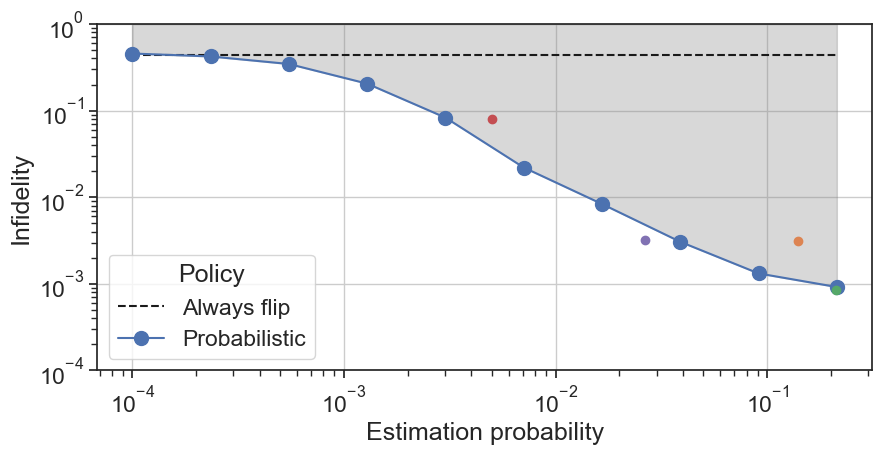

In [453]:
sns.set(font_scale=1.5,style="ticks")
plt.figure(figsize=(10, 4.5))
plt.hlines(p_flip(),probs[0],probs[-2],color="k",linestyles="--",label="Always flip")  
ms = 10
plt.plot(probs[:-1],infidelitiesf[0,:-1],"o-",ms=ms,label="Probabilistic")
#plt.plot(probs[:-1],infidelitiesf[1,:-1],"o-",ms=ms,label="Periodic")
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis='y', which='minor')
plt.xlabel("Estimation probability")
plt.ylabel("Infidelity")
plt.fill_between(probs[:-1],infidelitiesf[0,:-1],1,alpha=0.3, color="gray")
plt.grid(True)
#put log ticks
plt.legend(title="Policy", loc="lower left")
for dat in datas:
    plt.plot(dat.est_prob, dat.infidelity, "o")
plt.ylim(1e-4,1)


In [275]:
policies = []
for k in range(1):
    policies.append(data(results[k], 0))
    print(policies[k].est_prob)
    print(policies[k].fidelity)


0.04894
0.9712636426723866


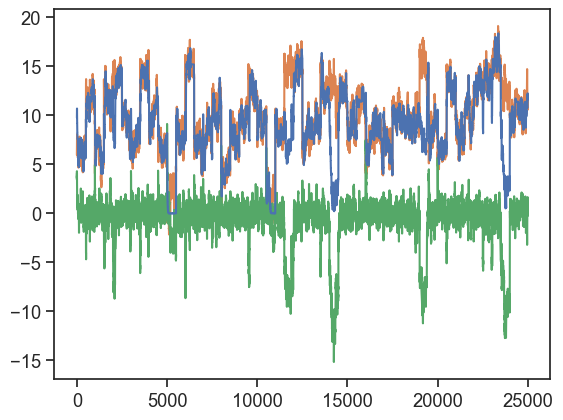

In [401]:
plt.plot(results[-1].mus,zorder=5)
plt.plot(results[-1].oms)
plt.plot(results[-1].errors)

In [172]:
data.return_row()

array([-0.01      ,  0.48831786,  0.05288   ,  0.93462   ,  0.98680209])

In [434]:


class data():
    def __init__(self, res, penalty):
        self.penalty = penalty
        self.actions = res.actions.flatten()
        self.rewards = res.rewards.flatten()
        self.mus = res.mus.flatten()
        self.oms = res.oms.flatten()
        self.stds = res.stds.flatten()*self.mus
        self.errors = self.mus-self.oms
        self.est_prob = np.sum(self.rewards==0)/len(self.rewards)
        self.succ_prob = np.sum(self.rewards==1)/len(self.rewards)
        self.fidelity = np.sum(self.rewards==1)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))
        self.infidelity = np.sum(self.rewards<0)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))

    def return_row(self):
        row = []
        row.append(self.penalty)
        row.append(np.mean(np.abs(self.errors)))
        row.append(self.est_prob)
        row.append(self.succ_prob)
        row.append(self.fidelity)
        return np.array(row)


In [454]:
om0 = 10
#penalty = [-0.1,-1,-5,-25]  #with ts = 1, max_time = 50
penalty = [-0.01,-10, -50]  # with ts = 5, max_time = 81
results = []
N = 100
for p in penalty:
    env = est.Moments_estimation(length = 20000, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  cs = 2,
                                  max_time = 500,
                                  penalty = p,
                                  time_step = 1,
                                  min_time = 1)
    #model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_bayes_tensorboard/", gamma = 1)
    model = model.load("../Code/logs2/t"+str(p)+"/best_model.zip")
   
    results.append(opt.game(N, env, model))

penalty = [-0.01,-1,-10,-20,-50]
for p in penalty:
    env = est.Moments_estimation_c(length = 20000, 
                                om0 = om0, 
                                noise = noiseou,
                                cs = 2,
                                max_time = 500,
                                penalty = p,
                                time_step = 1,
                                min_time = 1)
    model = model.load("../Code/logs2/c"+str(p)+"/best_model.zip")
   
    results.append(opt.game(N, env, model))



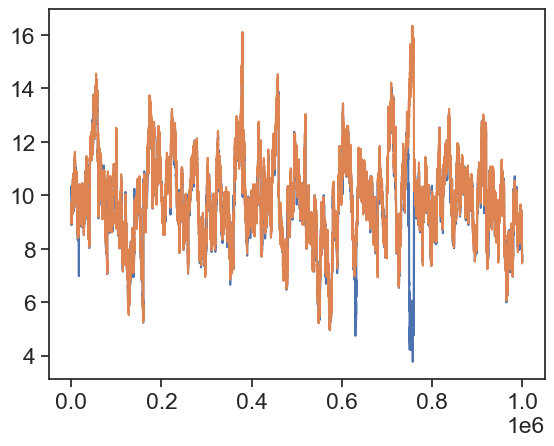

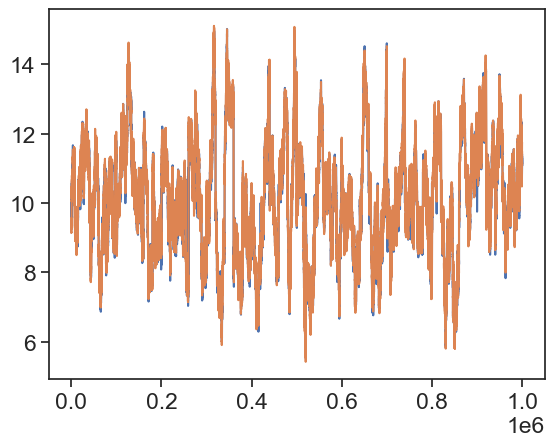

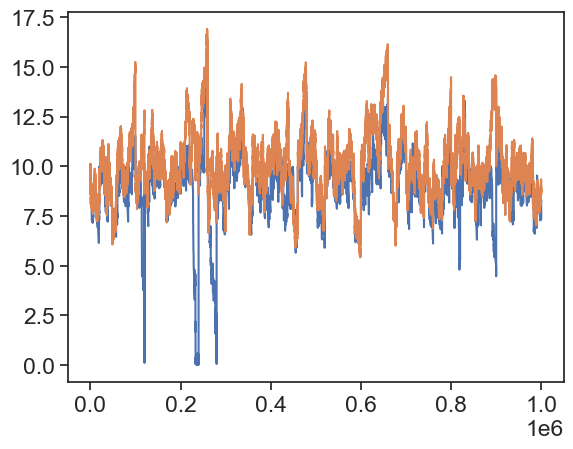

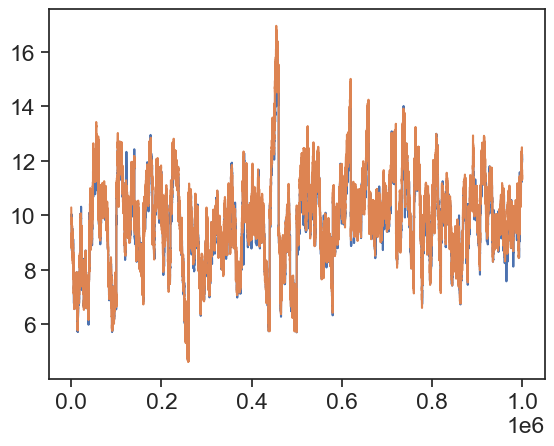

In [452]:
index = 52

In [447]:
datas[1].infidelity

0.0009099227199338975